# Product Grouping Analysis

## Summary

## 1. Initialize Packages and Functions 

This section initializes the necessary packages and defines auxiliary functions.

In [1]:
# read excel datasets 
import pandas as pd
import polars as pl

In [2]:
# Enable the underscore notation for polars columns, similar to ibis and dplyr (i.e., `pl.col("column_name")` -> `_.column_name`)
class PolarsColumnNamespace:
    def __getattr__(self, name):
        return pl.col(name)

# Enable _ as a shorthand for that class
_ = PolarsColumnNamespace()

## 2. Prepare Transactional Data 

### 2.1 Read Transactional Data 

- mention that these are two datasets from UCI

In [3]:
df1 = pl.read_excel('./online+retail/Online Retail.xlsx')
df2 = pl.read_excel('./online+retail+ii/online_retail_II.xlsx')
df2 = df2.rename({"Invoice": "InvoiceNo","Price": "UnitPrice", "Customer ID": "CustomerID"})
df = df1.vstack(df2)

### 2.2 Clean Up Dataset 


## 2.2.1 Missing Invoice IDs

- A number of records do not have an invoice id. We'll exclude them, because we cannot use them to determine the basket co-occurrence frequencies for the respective entries.
- This applies to $19_500$ rows, i.e., $1.8\%$ of the records

In [4]:
nrows_null = df.filter( _.InvoiceNo.is_null() ).shape[0]
nrows_total = df.shape[0]
(nrows_null, nrows_null / nrows_total)

(19500, 0.018269203743781444)

In [5]:
# drop rows with null InvoiceNo
df = df.filter( ~_.InvoiceNo.is_null() )

## 2.2.2 Missing or Incorrect Product Descriptions

- Some product descriptions indicate adjustments or comments rather than product names. In some cases, additional information is provided, and in others, they have been initially mislabeled.
- We'll exclude the corresponding transactions from the data.
- Exploratory analysis showed that nearly all proper product descriptions are uppercase, and those that are not fully uppercase are in title case.
    - Thus, one heuristic to identify anomalous descriptions is calculating the relative number of uppercase letters at the start of a word.

In [6]:
df = ( df
    .with_columns([
        # Extract the count of lowercase letters starting a word and store it in a new column
        _.Description.str.extract_all(r"[^A-Za-z][a-z]").list.len().alias("lowercase_start_count"),
        # Extract the count of uppercase letters starting a word and store it in a new column
        _.Description.str.extract_all(r"[^A-Za-z][A-Z]").list.len().alias("uppercase_start_count")
    ])
    .with_columns([
        # Create a boolean column indicating if there are no letters starting a word
        ( (_.lowercase_start_count == 0) & (_.uppercase_start_count == 0) ).alias("no_letter_start"),
        # Create a boolean column indicating if there are more lowercase letters starting words than uppercase
        (  _.lowercase_start_count > _.uppercase_start_count ).alias("largely_lowercase_start")
    ])
    .with_columns([
        # Create a final boolean column indicating if the description is anomalous
        ( _.largely_lowercase_start | _.no_letter_start | _.Description.is_null() ).alias("is_anomalous_description")
    ])
    # Drop the intermediate columns used for calculations
    .drop(["lowercase_start_count", "uppercase_start_count", "no_letter_start", "largely_lowercase_start"])
)

In [7]:
#  Verify that all descriptions classified as anomalous are so indeed
print(df.filter(_.is_anomalous_description)["Description"].unique().to_list())

['faulty', 'Damp and rusty', 'Rusty connections', 'wet damages', 'did  a credit  and did not tick ret', 'update', 'mixed up', 'Had been put aside.', 'amendment', 'rex use', '??', 'dotcom sold sets', 'wrong ctn size', 'damages wax', 'adjustment', 'wrongly marked. 23343 in box', 'amazon adjust', 'for online retail orders', 'check', 'historic computer difference?....se', 'wet rusty', 'wedding co returns?', 'Damages', 'sold as set/6 on dotcom', 'Dotcom sold as set', 'found some more on shelf', 'display', 'check?', 'damages', 'missings', '???', 'Ebay sales by the box.', 'incorrectly credited C550456 see 47', 'found', 'had been put aside', 'Dotcom multiples', 'mouldy, thrown away.', 'reverse 21/5/10 adjustment', '22719', 'stock take', 'reverse previous adjustment', 'Sold as 1 on dotcom', 'FOUND', 'donated to the Food Chain charity.', 'wrong code?', 'Zebra invcing error', 'wrongly sold (22719) barcode', 'wrongly marked carton 22804', '? sold as sets?', 'Display', 'damaged?', 'dirty', 'debenha

In [8]:
# Check all the remaining product descriptions
print(df.filter(~_.is_anomalous_description)["Description"].unique().to_list())

['KIDS CUTLERY DOLLY GIRL ', 'METAL SIGN HIS DINNER IS SERVED', 'PARTY PIZZA DISH BLUE POLKADOT', '12 PENCILS TALL TUBE RED SPOTTY', 'SCALLOP SHELL SOAP DISH', 'PACK OF 12 WOODLAND TISSUES ', 'LOVELY BONBON STICKER SHEET', 'GARDENERS KNEELING PAD', 'ENGLISH ROSE METAL WASTE BIN', 'RECYCLED ACAPULCO MAT LAVENDER', 'PINK/WHITE CHRISTMAS TREE 60CM', 'GOLD  CHERRY LIGHTS', 'SPRING DEC , HANGING CHICK CREAM', 'LONDON BUS COFFEE MUG', 'PURPLE VINTAGE EARRINGS', 'SKULL LUNCH BOX WITH CUTLERY ', 'DOLLY CABINET 2 DRAWERS ', 'CREAM WALL PLANTER HEART SHAPED', 'BLUE GINGHAM ROSE CUSHION COVER', 'BATHROOM SCALES RUBBER DUCKS', 'SLEEPING CAT ERASERS', 'RECIPE BOX RETROSPOT ', 'CHRYSANTHEMUM SKETCHBOOK ', 'WATERMELON BATH SPONGE', 'SILVER LARIAT 40CM', 'ICE CREAM DESIGN GARDEN PARASOL', 'WALL ART GARDEN HAVEN ', '15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'HANGING WOOD AND FELT BUTTERFLY ', 'TRADITIONAL KNITTING NANCY', 'WOODLAND LARGE PINK FELT HEART', 'FOOD CONTAINER SET 3 LOVE HEART ', 'PINK BERTIE MO

- This applies to 4193 rows, i.e., $0.4\%$ of the records

In [9]:
nrows_anomalous_description = df.filter(_.is_anomalous_description).shape[0]
nrows_total = df.shape[0]
(nrows_anomalous_description, nrows_anomalous_description / nrows_total)

(8575, 0.0081832670083121)

In [10]:
# Extract the transaction IDs associated with anomalous descriptions
anomalous_transactions = df.filter(_.is_anomalous_description).select(_.InvoiceNo).with_columns([pl.lit(True).alias("is_anomalous_invoice")])

df = (df
    # Join the main dataframe with the anomalous transactions to mark them
    .join(anomalous_transactions, on="InvoiceNo", how="left")
    # Filter out the rows where the invoice is marked as anomalous
    .filter(_.is_anomalous_invoice.is_null())
    # Drop the columns used for marking and filtering
    .drop(["is_anomalous_description", "is_anomalous_invoice"])
)

## 2.3 Separate Transaction and Product Information

- Here, we separate the transaction and product information

In [11]:
transactions_df = df.select(_.InvoiceNo, _.StockCode)
products_df = df.select(_.StockCode, _.Description).unique()

## 3. Product Description Embeddings

### 3.1 Create Unique Product Descriptions 

In [12]:
# Group by StockCode and count the occurrences, then sort by count in descending order and get the list of StockCodes
stock_codes = (products_df
    .group_by(_.StockCode)
    .count()
    .sort(_.count, descending=True)
)["StockCode"].to_list()

# Create a pivot table with StockCode as the index and Description as the values
unique_product_descriptions = (products_df
    # Add a row index for each StockCode
    .with_columns( pl.arange(0, pl.count()).over("StockCode").alias("row_idx"))
    .pivot( values="Description", index="row_idx", on="StockCode", aggregate_function="first")
)[stock_codes]

/tmp/ipykernel_228651/2875576161.py:4: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/tmp/ipykernel_228651/2875576161.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .with_columns( pl.arange(0, pl.count()).over("StockCode").alias("row_idx"))


In [13]:
# Display the pivot table
unique_product_descriptions

20685,23196,21955,22344,22384,22346,23236,22345,20750,23209,22845,22776,21524,17107D,22937,23126,22502,22844,84997b,22191,22952,23396,84997B,84997a,22333,23131,21243,22853,22201,22356,23240,22416,22852,23231,23535,22197,23366,…,21303,21679,21563,21981,84247L,82582,23013,21488,21792,37482B,21426,90003E,72740A,21110,20829,20869,22518,84820,90152B,21028,22961,90138,23088,37489A,23006,84422,23211,23227,85049d,85049A,47591d,22480,90126A,20954,90176B,72529w,84536a
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""DOOR MAT RED SPOT""","""VINTAGE LEAF MAGNETIC NOTEPAD""","""UNION JACK GUNS & ROSES DOORM…","""PARTY PIZZA DISH PINK RETROSPO…","""LUNCHBAG PINK RETROSPOT""","""PARTY PIZZA DISH GREEN POLKADO…","""STORAGE TIN VINTAGE DOILY ""","""PARTY PIZZA DISH BLUE+WHITE SP…","""RED RETROSPOT MINI CASES""","""LUNCH BAG VINTAGE DOILEY ""","""VINTAGE CAT FOOD CONTAINER""","""CAKESTAND, 3 TIER, LOVEHEART""","""DOOR MAT SPOTTY HOME SWEET HOM…","""FLOWER FAIRY,5 SUMMER B'DRAW L…","""BAKING MOULD CHOCOLATE CUPCAKE…","""DOLLCRAFT GIRL AMELIE""","""PICNIC BASKET WICKER SMALL""","""DOG FOOD CONTAINER , VINTAGE""","""RED 3 PIECE MINI DOTS CUTLERY …","""EAU DE NIL DINER WALL CLOCK""","""72 CAKE CASES VINTAGE CHRISTMA…","""LA JARDIN BOTANIQUE CUSHION CO…","""RED 3 PIECE RETROSPOT CUTLERY …","""GREEN 3 PIECE MINI DOTS CUTLER…","""RETROSPOT PARTY BAG + STICKER …","""MISELTOE HEART WREATH CREAM""","""PINK SPOTTY PLATE ""","""ENAMEL CAT BOWL CREAM""","""FRYING PAN BLUE POLKADOT""","""CHARLOTTE BAG PINK POLKADOT""","""SET OF 4 KNICK KNACK TINS DOIL…","""SET OF 36 SPACEBOY PAPER DOILI…","""DOG BOWL VINTAGE CREAM""","""WRAP DOILEY DESIGN""","""WALL ART BICYCLE SAFETY""","""SMALL POPCORN HOLDER""","""SET 12 COLOUR PENCILS DOILEY""",…,"""FILIGREE WALL MIRROR ANTIQUE …","""SKULLS STICKERS""","""RED HEART SHAPE LOVE BUCKET ""","""PACK OF 12 WOODLAND TISSUES ""","""FAWN AND MUSHROOM GREETING CAR…","""AREA PATROLLED METAL SIGN""","""GLASS APOTHECARY BOTTLE TONIC""","""RED WHITE SCARF HOT WATER BOT…","""CLASSIC FRENCH STYLE BASKET GR…","""CUBIC MUG BLUE POLKA DOT""","""WOODLAND STORAGE BOX SMALL""","""GREEN PAIR HEART HAIR SLIDES""","""LARGE STRAWBERRY CHOCOLATE CAN…","""LARGE CAKE TOWEL PINK SPOTS""","""GLITTER HANGING BUTTERFLY STRI…","""GOLD FABRIC MIRROR""","""CHILDS GARDEN BRUSH BLUE""","""DANISH ROSE TRINKET TRAYS""","""BLUE/GREEN SHELL NECKLACE W PE…","""NINJA RABBIT BLACK""","""JAM MAKING SET PRINTED""","""WHITE/PINK MINI CRYSTALS NECKL…","""ZINC HEART FLOWER T-LIGHT HOLD…","""YELLOW/PINK FLOWER DESIGN BIG …","""TRAVEL CARD WALLET FLOWER MEAD…","""PINK/BLUE DISC/MIRROR STRING""","""RED ROCKING HORSE HAND PAINTED""","""FILIGREE HEART BUTTERFLY WHITE…","""BRIGHT BLUES RIBBONS ""","""TRADITIONAL CHRISTMAS RIBBONS""","""PINK FAIRY CAKE CHILDRENS APRO…","""RED TEA TOWEL CLASSIC DESIGN""","""PINK BERTIE MOBILE PHONE CHARM""","""*USB Office Mirror Ball""","""DIAMANTE NECKLACE BLACK ""","""WHITE ADVENT CANDLE""","""ENGLISH ROSE NOTEBOOK A7 SIZE"""
"""DOORMAT RED RETROSPOT""","""RETO LEAVES MAGNETIC SHOPPING …","""DOOR MAT UNION JACK GUNS AND R…","""PARTY PIZZA DISH PINK WHITE SP…","""LUNCH BAG PINK POLKADOTS""","""PARTY PIZZA DISH GREEN RETROSP…","""DOILEY BISCUIT TIN""","""PARTY PIZZA DISH BLUE POLKADOT""",""" RED/WHITE DOT MINI CASES""","""LUNCH BAG VINTAGE DOILY ""","""VINTAGE CREAM CAT FOOD CONTAIN…","""SWEETHEART CAKESTAND 3 TIER""","""DOORMAT SPOTTY HOME SWEET HOME""","""FLOWER FAIRY 5 SUMMER DRAW LIN…","""BAKING MOULD CHOCOLATE CUP CAK…","""FELTCRAFT GIRL AMELIE KIT""","""PICNIC BASKET WICKER 60 PIECES""","""VINTAGE DOG FOOD CONTAINER""","""RED 3 PIECE RETROSPOT CUTLERY …","""IVORY WALL CLOCK""","""SET 72 CAKE CASES VINTAGE CHRI…","""BUTTERFLY CUSHION COVER""","""RED 3 PIECE MINI DOTS CUTLERY …","""CHILDRENS C

In [14]:
product_descriptions = products_df.group_by("StockCode").agg(
    pl.col("Description").str.concat(" / ").alias("Description")
)

In [15]:
product_descriptions

StockCode,Description
str,str
"""90174""","""BUTTERFLY HAIR BAND"""
"""21504""","""SKULLS GREETING CARD"""
"""22673""","""FRENCH GARDEN SIGN BLUE METAL"""
"""78026""","""SEAGRASS S/3 SQU LAUNDRY BOX"""
"""21110""","""LARGE CAKE TOWEL PINK SPOTS"""
…,…
"""22465""","""HANGING METAL STAR LANTERN"""
"""21923""","""RED/CREAM STRIPE FRINGE HAMMOC…"
"""23236""","""STORAGE TIN VINTAGE DOILY / D…"


### 3.2 Create Description Embeddings

In [16]:
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

In [17]:
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["SIM_EMBEDDINGS_CORES"] = "8"

import multiprocessing
multiprocessing.set_start_method("forkserver", force=True)

import torch
cores = int(os.environ["SIM_EMBEDDINGS_CORES"])
torch.set_num_threads(cores) 

import sentence_transformers as st

## set transformer model 
#py_model_name = 'all-MiniLM-L6-v2' # primarily English
#py_model_name = 'paraphrase-multilingual-MiniLM-L12-v2' # multilingual
py_model_name = 'LaBSE' 
#py_model_name = 'xlm-r-100langs-bert-base-nli-stsb-mean-tokens' 

# runner ups to try, according to ChatGPT:
# - XLM-RoBERTa
# - mBART-50
# - MT5 (Multilingual T5)
# - ByT5 (handles raw text at the byte level, ideal for multilingual similarity tasks).
# - mLUKE (multilingual version of LUKE, good for named entity recognition and contextual understanding).
# - mBERT (baseline multilingual BERT, effective but less performant than XLM-R).

In [18]:

def encode_semantic_embeddings(ids, desc=None, prompt = None, fname_cache = None):
  """ """
  if not desc is None:
    desc = ids

  if (not fname_cache is None) and os.path.exists(fname_cache):
      embeddings = None
      with open(fname_cache, "rb") as f:
        embeddings = pickle.load(f)
      return embeddings

  py_model = st.SentenceTransformer(py_model_name)
  
  embeddings = py_model.encode(
      sentences = desc, 
      prompt = prompt,
      show_progress_bar = True,
      use_multiprocessing=True
      #normalize_embeddings = True # note: apparently dot products can be used instead of cosine sim, if normalized
  )

  if (not fname_cache is None):
      with open(fname_cache, "wb") as f:
          pickle.dump(embeddings, f)

  return embeddings



In [19]:
fname_dkt_embeddings = "./product_desc_embeddings.pkl"
product_ids = product_descriptions["StockCode"].to_list()
description = product_descriptions["Description"].to_list()
embeddings_semantic = encode_semantic_embeddings(ids = product_ids, desc = description, fname_cache = fname_dkt_embeddings)

## 4. Product Co-Occurrence Embeddings

In [20]:
transactions = transactions_df.group_by("InvoiceNo").agg(
    pl.col("StockCode").alias("products")
)["products"].to_list()

In [21]:
def resample_transactions(transactions):
    """Resample and shuffle transactions to create a new dataset."""
    
    # Define a lambda function to shuffle a list
    shuffle = lambda lst: random.sample(lst, k=len(lst))

    # Resample the transactions to create a new dataset
    resampled_transactions = shuffle(transactions)  # Resample with replacement
    shuffled_transactions = [shuffle(transaction) for transaction in resampled_transactions]  # Shuffle the sentences

    return shuffled_transactions

In [22]:
from gensim.models import Word2Vec
import random
from tqdm import tqdm

def encode_word2vec_emebddings(product_ids, transactions, embedding_size = 100, window = 5, min_count = 1, n_bootstrap = 50):
    """ """

    # Number of resamples
    bootstrap_embeddings = []

    for _ in tqdm( range(n_bootstrap) ):
        resampled_transactions = resample_transactions(transactions)  # Resample with replacement and re-shuffle the transactions
        model = Word2Vec(resampled_transactions, vector_size=embedding_size, window=window, min_count=min_count, sg=0, workers=4)
        bootstrap_embeddings.append({word: model.wv[word] for word in model.wv.index_to_key})
        
    embeddings = []
    for product_id in tqdm( product_ids ):
        product_embeddings = [embedding[product_id] for embedding in bootstrap_embeddings]
        aggregated_embedding = np.mean(product_embeddings, axis=0)
        embeddings.append( aggregated_embedding )

    return embeddings

In [23]:
%%time
embeddings_word2vec = encode_word2vec_emebddings(product_ids, transactions, embedding_size = 100, window = 5, min_count = 1, n_bootstrap = 50)





  2%|▏         | 1/50 [00:05<04:39,  5.70s/it]


KeyboardInterrupt: 

In [ ]:
embeddings = np.column_stack((embeddings_semantic, embeddings_word2vec))
embeddings.shape


(4896, 868)

In [ ]:
from sklearn.decomposition import PCA

n_pca_components = 100
pca = PCA(n_components=n_pca_components)
embeddings_pca = pca.fit_transform(embeddings)

In [ ]:
from plotnine import *

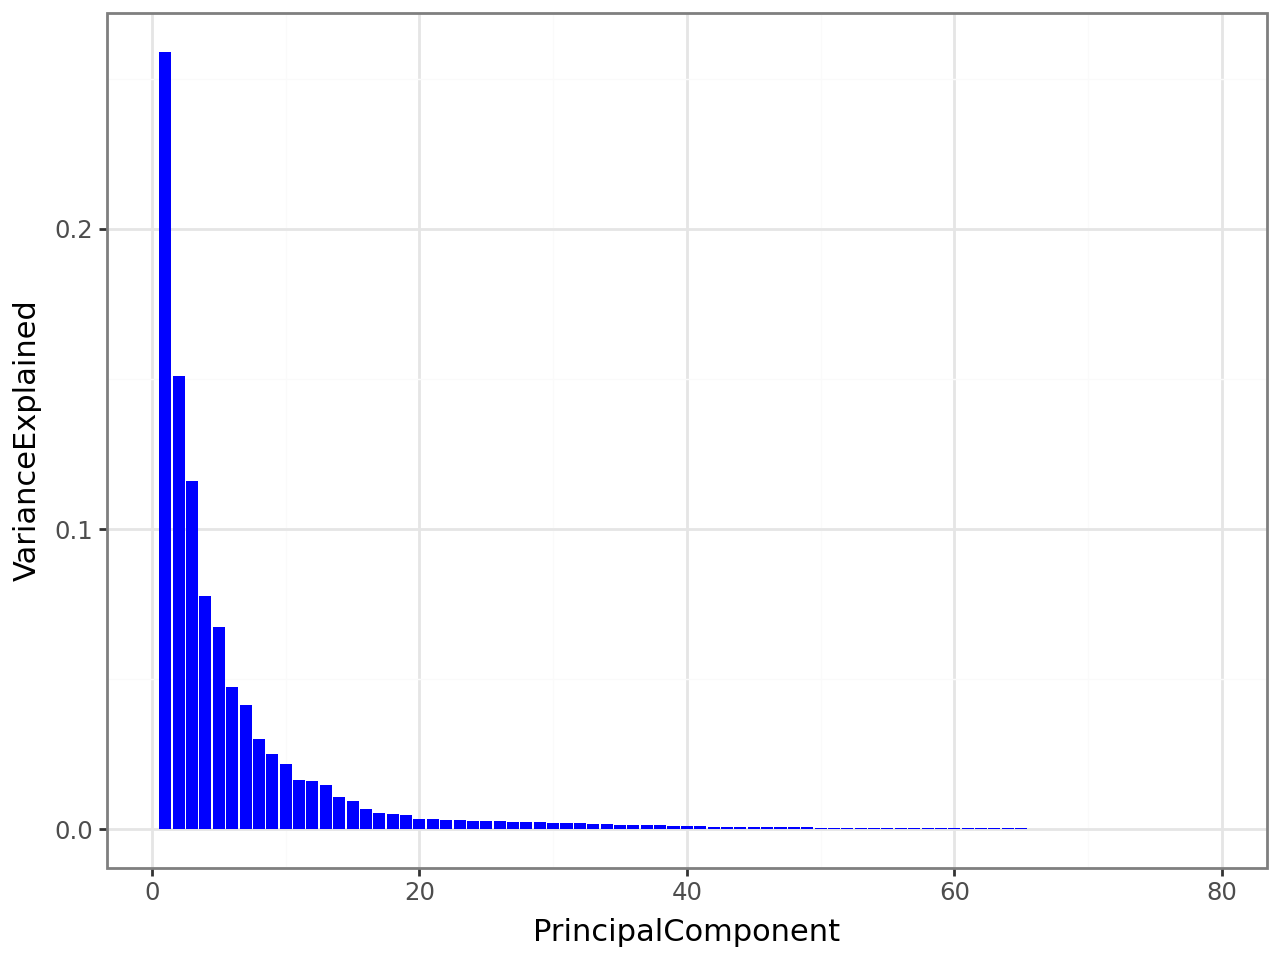

In [ ]:
n_components = 80
plot_df = pd.DataFrame({'PrincipalComponent': range(1, n_components), 'VarianceExplained': pca.explained_variance_ratio_[:(n_components-1)]})
ggplot(plot_df, aes(x="PrincipalComponent", y="VarianceExplained")) + geom_bar(stat = "identity", fill = "blue") + theme_bw()

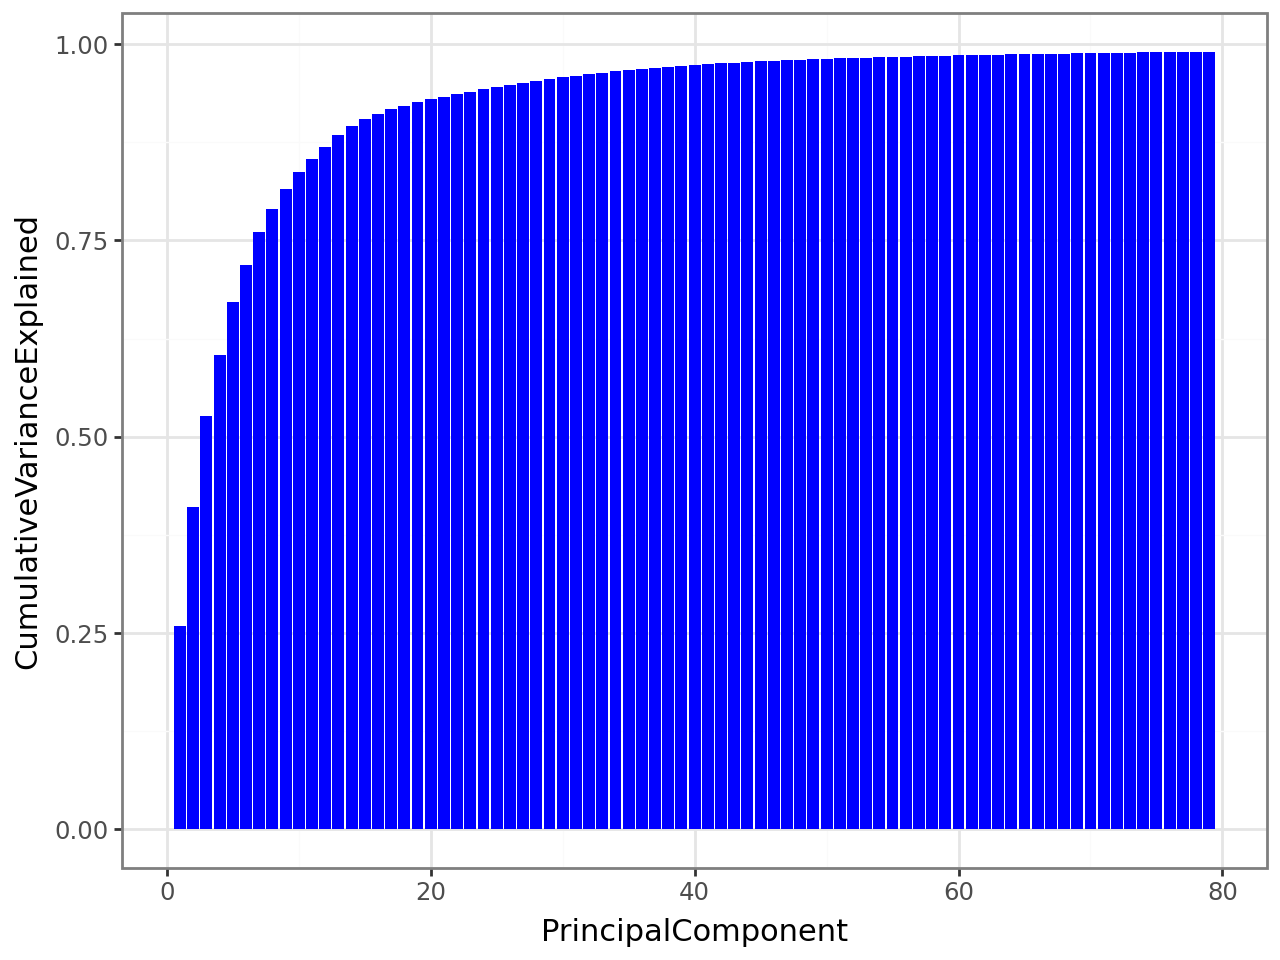

In [ ]:

plot_df = pd.DataFrame({'PrincipalComponent': range(1, n_components), 'CumulativeVarianceExplained': np.cumsum(pca.explained_variance_ratio_[:(n_components-1)]) })
ggplot(plot_df, aes(x="PrincipalComponent", y="CumulativeVarianceExplained")) + geom_bar(stat = "identity", fill = "blue") + theme_bw()

## 5. Similarity Quantification

In [ ]:
sim = cosine_similarity(embeddings_pca, embeddings_pca)
distance = 1 - sim

In [ ]:
from scipy.spatial.distance import squareform
condensed_distance = squareform(distance, checks=False)  # scipy needs condensed distance


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(condensed_distance, method='average')  # or 'average', 'complete', etc.


In [ ]:
%pip install dash
%pip install dash_cytoscape

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 7.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for stringcase: filename=stringcase-1.2.0-py3-none-any.whl size=3604 sha256=baf69379c73f85394d8ed3a10f50342700e75328d30850a6dc082da303891f2c
  Stored in directory: /home/pavel/.cache/pip/wheels/31/ba/22/1a2d952a9ce8aa86e42fda41e2c87fdaf20e238c88bf8df013
Successfully built stringcase
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import dash
import dash_cytoscape as cyto
from dash import html

app = dash.Dash(__name__)

app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape',
        layout={'name': 'breadthfirst'},  # иерархический layout
        style={'width': '100%', 'height': '800px'},
        elements=[
            {'data': {'id': 'A', 'label': 'Product A'}},
            {'data': {'id': 'B', 'label': 'Product B'}},
            {'data': {'source': 'A', 'target': 'B'}}
        ]
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)


ObsoleteAttributeException: app.run_server has been replaced by app.run

: 

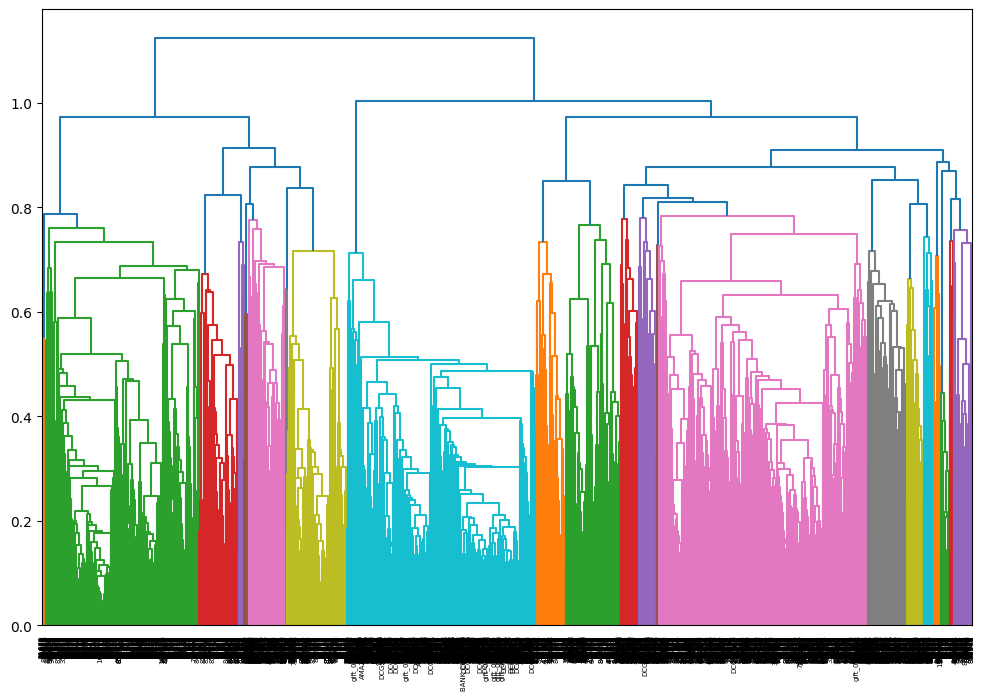

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(12, 8))
dendrogram(Z, labels=product_ids, leaf_rotation=90)
plt.show()


In [ ]:

def normalize_embeddings(embeddings):
  """ """
  return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)


In [ ]:

def cluster_embeddings(embeddings_normalized, n_clusters):
  """ """
  # MiniBatch KMeans
  kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, random_state=42)
  labels = kmeans.fit_predict(embeddings_normalized)
  return labels

def _construct_similarities_df(similarities_mat, threshold_upper, threshold_lower):
  """ """
  # Get the indices where the condition is met
  p1_index_local, p2_index_global = None, None
  if (not threshold_upper is None) and (not threshold_lower is None):
      p1_index_local, p2_index_global = np.where(similarities_mat > threshold_upper and similarities_mat < threshold_lower)

  elif (not threshold_upper is None):
      p1_index_local, p2_index_global = np.where(similarities_mat > threshold_upper)

  elif (not threshold_lower is None):
      p1_index_local, p2_index_global = np.where(similarities_mat < threshold_lower)
      
  else:
      p1_index_local, p2_index_global = np.where(similarities_mat == similarities_mat)
    

  similarities_df = pd.DataFrame({
      'p1_index_local': p1_index_local,
      'p2_index_global': p2_index_global,
      'sim': similarities_mat[p1_index_local, p2_index_global]
  })
  
  return similarities_df

  
def similarity_outside_thresholds(embeddings, ids, n_clusters, threshold_upper = None, threshold_lower = None ):
  """ """
  assert (not (threshold_upper is None and threshold_lower is None))
  
  embeddings_normalized = normalize_embeddings( embeddings )
  labels = cluster_embeddings(embeddings_normalized, n_clusters = n_clusters)

  index_global = range(0, len(labels))
  ids_df = pd.DataFrame({"index_global": index_global, "id": ids, "group": labels})
  p2_info = (ids_df[["index_global", "id"]].rename(columns={"id": "p2_id", "index_global": "p2_index_global"}))

  ids_groups = [group for _, group in ids_df.groupby("group")]
  similarities_lst = []

  #cur_ids_group = ids_groups[0]
  for cur_ids_group in tqdm(ids_groups, desc="Processing groups", unit="group"): #ids_groups: #s[:2]:
      cur_ids_group["index_local"] = range(0, cur_ids_group.shape[0])
      cur_indices = cur_ids_group["index_global"].to_list()
      cur_embeddings_normalized = embeddings_normalized[cur_indices]
  
      cur_similarities_mat = cosine_similarity(cur_embeddings_normalized, embeddings_normalized)
      cur_similarities_df = _construct_similarities_df(cur_similarities_mat, threshold_upper, threshold_lower)
      
      cur_p1_info = (cur_ids_group[["index_local", "index_global", "id"]].rename(columns={"id": "p1_id", "index_global": "p1_index_global"}))
      cur_similarities_df = (cur_similarities_df
          .merge( cur_p1_info, how = "left", left_on = "p1_index_local", right_on = "index_local")
          .merge( p2_info, how = "left", on = "p2_index_global" )
      )

      #cur_similarities_df.drop(columns=["index_local", "p1_index_local"], inplace=True)
      similarities_lst.append(cur_similarities_df)

  similarities_df = pd.concat(similarities_lst, ignore_index=True)
  similarities_df = similarities_df[['p1_id', 'p2_id', 'p1_index_global', 'p2_index_global', 'sim']]

  similarities_df = similarities_df[ similarities_df["p1_index_global"] != similarities_df["p2_index_global"] ] 

  return similarities_df.sort_values("sim", ascending = False)

In [ ]:
# Build and train the CBOW model
model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=2, sg=1, min_count=1, workers=4)


In [ ]:
products.group_by(_.StockCode).count().sort(_.count, descending=True).head(10).transpose(include_header=True, header_name="StockCode", column_names=df_wide["StockCode"].to_list())

In [ ]:
products.filter( _.StockCode == "23236")#.filter(pl.col("Description").str.contains(r"marked"))

In [ ]:
df2

In [ ]:
df2.filter( _.Description == 'JUMBO STORAGE BAG SUKI' )